In [20]:
import sys
sys.path.append("../../..")
import numpy as np
import joblib
data = joblib.load("../../../persist_data/atari_vf_fit.pkl")

In [42]:
import time
%load_ext autoreload
%autoreload 2

from rllab.baseline.gaussian_mlp_baseline import GaussianMLPBaseline
from rllab.misc.ext import AttrDict
from rllab.optimizer.lbfgs_optimizer import LbfgsOptimizer
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
policy = data["policy"]
mdp = data["mdp"]
paths = data["paths"]

In [4]:
n_train_paths = int(len(paths) * 0.7)
n_test_paths = len(paths) - n_train_paths

train_paths = paths[:n_train_paths]
test_paths = paths[n_train_paths:]

train_xs = np.concatenate([p["observations"] for p in train_paths])
train_ys = np.concatenate([p["returns"] for p in train_paths])
test_xs = np.concatenate([p["observations"] for p in test_paths])
test_ys = np.concatenate([p["returns"] for p in test_paths])

In [9]:
# Fix the initial baseline parameters
np.random.seed(0)
baseline = GaussianMLPBaseline(
    mdp,
)
init_params = baseline.get_param_values()
print np.linalg.norm(init_params)

9.19627


In [37]:
# Let's inspect training loss first

lbfgs_losses = []
lbfgs_times = []

def opt_callback(params):
    if params['itr'] > 0 and params['itr'] % 20 == 0:
        print "[L-BFGS] Trainig loss after training %d itr: %f; took %.2fs so far" % (params['itr'], params['loss'], params['elapsed'])
        lbfgs_losses.append(params['loss'])
        lbfgs_times.append(params['elapsed'])

baseline = GaussianMLPBaseline(
    mdp,
    regressor_args=dict(
        use_trust_region=False,
        learn_std=False,
        init_std=0.1,
        optimizer=LbfgsOptimizer(max_opt_itr=2000, callback=opt_callback)
    ),
)
baseline.set_param_values(init_params)
baseline.fit(train_paths)

[L-BFGS] Trainig loss after training 20 itr: 1.056590; took 1.36s so far
[L-BFGS] Trainig loss after training 40 itr: 1.024146; took 2.65s so far
[L-BFGS] Trainig loss after training 60 itr: 1.000380; took 4.02s so far
[L-BFGS] Trainig loss after training 80 itr: 0.986987; took 5.43s so far
[L-BFGS] Trainig loss after training 100 itr: 0.984488; took 6.88s so far
[L-BFGS] Trainig loss after training 120 itr: 0.983671; took 8.25s so far
[L-BFGS] Trainig loss after training 140 itr: 0.983187; took 9.66s so far
[L-BFGS] Trainig loss after training 160 itr: 0.982885; took 10.91s so far
[L-BFGS] Trainig loss after training 180 itr: 0.982610; took 12.19s so far
[L-BFGS] Trainig loss after training 200 itr: 0.982370; took 13.52s so far
[L-BFGS] Trainig loss after training 220 itr: 0.982139; took 14.76s so far
[L-BFGS] Trainig loss after training 240 itr: 0.981999; took 16.09s so far
[L-BFGS] Trainig loss after training 260 itr: 0.981777; took 17.42s so far
[L-BFGS] Trainig loss after training

In [38]:
records = dict()
records["lbfgs"] = (lbfgs_times, lbfgs_losses)

In [47]:
from rllab.optimizer.minibatch_optimizer import MinibatchOptimizer

for learning_rate in [1e-3, 7.5e-4, 5e-4, 2.5e-4, 1e-4]:
    adam_losses = []
    adam_times = []
    # # Let's inspect training loss first
    def opt_callback(params):
        if params['itr'] > 0 and params['itr'] % 20 == 0:
            print "[Adam %f] Trainig loss after training %d itr: %f; took %.2fs so far" % (learning_rate, params['itr'], params['loss'], params['elapsed'])
            adam_losses.append(params['loss'])
            adam_times.append(params['elapsed'])

    baseline = GaussianMLPBaseline(
        mdp,
        regressor_args=dict(
            use_trust_region=False,
            learn_std=False,
            init_std=0.1,
            optimizer=MinibatchOptimizer(update_method='adam', max_epochs=1000, tolerance=-1, batch_size=512, callback=opt_callback, learning_rate=learning_rate)
        ),
    )
    baseline.set_param_values(init_params)
    baseline.fit(train_paths)

    records["adam_%f" % learning_rate] = (adam_times, adam_losses)

[Adam 0.001000] Trainig loss after training 20 itr: 1.030740; took 3.32s so far
[Adam 0.001000] Trainig loss after training 40 itr: 1.014649; took 6.47s so far
[Adam 0.001000] Trainig loss after training 60 itr: 1.000791; took 9.63s so far
[Adam 0.001000] Trainig loss after training 80 itr: 0.994173; took 12.78s so far
[Adam 0.001000] Trainig loss after training 100 itr: 0.981149; took 15.94s so far
[Adam 0.001000] Trainig loss after training 120 itr: 0.964587; took 19.09s so far
[Adam 0.001000] Trainig loss after training 140 itr: 0.961113; took 22.24s so far
[Adam 0.001000] Trainig loss after training 160 itr: 0.954337; took 25.40s so far
[Adam 0.001000] Trainig loss after training 180 itr: 0.948397; took 28.55s so far
[Adam 0.001000] Trainig loss after training 200 itr: 0.943874; took 31.70s so far
[Adam 0.001000] Trainig loss after training 220 itr: 0.942304; took 34.86s so far
[Adam 0.001000] Trainig loss after training 240 itr: 0.942540; took 38.01s so far
[Adam 0.001000] Trainig

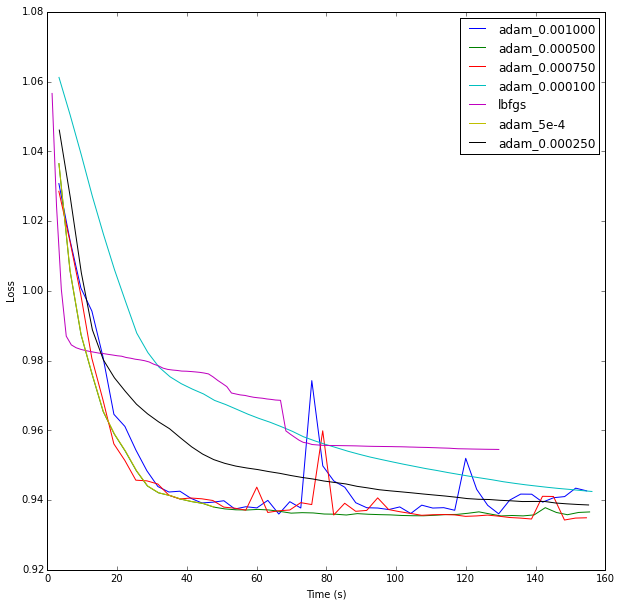

In [53]:
plots = []
legends = []
fig = plt.figure(figsize=(10,10))
for k, v in records.items():
    plots.append(plt.plot(*v)[0])
    legends.append(k)
plt.legend(plots, legends)
plt.xlabel("Time (s)")
plt.ylabel("Loss")

In [ ]:
from rllab.optimizer.minibatch_optimizer import MinibatchOptimizer

for learning_rate in [5e-4]:
    for batch_size in [512, 256, 128, 64, 32]:
        adam_losses = []
        adam_times = []
        # # Let's inspect training loss first
        def opt_callback(params):
            if params['itr'] > 0 and params['itr'] % 20 == 0:
                print "[Adam %f] Trainig loss after training %d itr: %f; took %.2fs so far" % (learning_rate, params['itr'], params['loss'], params['elapsed'])
                adam_losses.append(params['loss'])
                adam_times.append(params['elapsed'])

        baseline = GaussianMLPBaseline(
            mdp,
            regressor_args=dict(
                use_trust_region=False,
                learn_std=False,
                init_std=0.1,
                optimizer=MinibatchOptimizer(update_method='adam', max_epochs=1000, tolerance=-1, batch_size=batch_size, callback=opt_callback, learning_rate=learning_rate)
            ),
        )
        baseline.set_param_values(init_params)
        baseline.fit(train_paths)

        records["adam_%f_batch_size_%d" % (learning_rate, batch_size)] = (adam_times, adam_losses)

[Adam 0.000500] Trainig loss after training 20 itr: 1.036455; took 3.46s so far
[Adam 0.000500] Trainig loss after training 40 itr: 1.005794; took 6.66s so far
[Adam 0.000500] Trainig loss after training 60 itr: 0.987406; took 9.86s so far
[Adam 0.000500] Trainig loss after training 80 itr: 0.976038; took 13.07s so far
[Adam 0.000500] Trainig loss after training 100 itr: 0.965401; took 16.27s so far
[Adam 0.000500] Trainig loss after training 120 itr: 0.958955; took 19.47s so far
[Adam 0.000500] Trainig loss after training 140 itr: 0.954014; took 22.67s so far
[Adam 0.000500] Trainig loss after training 160 itr: 0.948398; took 25.87s so far
[Adam 0.000500] Trainig loss after training 180 itr: 0.944034; took 29.07s so far
[Adam 0.000500] Trainig loss after training 200 itr: 0.942072; took 32.27s so far
[Adam 0.000500] Trainig loss after training 220 itr: 0.941313; took 35.47s so far
[Adam 0.000500] Trainig loss after training 240 itr: 0.940278; took 38.67s so far
[Adam 0.000500] Trainig